In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.visualization import *
from decode_fish.funcs.predict import predict

from numba import njit
from scipy.spatial import cKDTree
from decode_fish.funcs.evaluation import *

import io, requests, glob

from decode_fish.funcs.merfish_eval import *
from decode_fish.funcs.exp_specific import *
# from starfish import data
import pprint
import seaborn as sns

# import plotly.express as px
# import plotly.io as pio
# pio.renderers.default='notebook'

In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [13]:
bench_df = get_mop_benchmark()
code_ref, targets = get_mop_codebook()

17130008


In [14]:
max_p_150 = cpu(read_MOp_tiff(base_path+'/datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/aligned_images150.tif', scaled=True, z_to_batch=True)).max(0).max(0)[0]
max_p_151 = cpu(read_MOp_tiff(base_path+'/datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/aligned_images151.tif', scaled=True, z_to_batch=True)).max(0).max(0)[0]
max_p_47 = cpu(read_MOp_tiff(base_path+'/datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/aligned_images47.tif', scaled=True, z_to_batch=True)).max(0).max(0)[0]

In [15]:
logr_coefs = {'x_sig': 0.03480553, 'y_sig': 0.02517798, 'z_sig': 0.02675353, 'prob': -2.34418526}

In [16]:
fids_150 = get_peaks(max_p_150, 18000, 20)
fids_151 = get_peaks(max_p_151, 18000, 20)
fids_47 = get_peaks(max_p_47, 18000, 20)

In [11]:
select = ['base']#,'bs:20xcrop_sz:56xbl_loss_scale:0.003','crop_sz:56','bs:15','bs:20']

sweep_name = 'sweep_mop_14'
file_nrs = [150,151,47]

out_dir = f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_MOp/{sweep_name}/*'
files = glob.glob(out_dir)
base_str = 'bsub -gpu "num=1" -q gpu_rtx -n 3 -o logs/ofish.log -e logs/efish.log /groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/merfish_eval.py '

with open('run_slurm.sh', 'w') as f:
    for nr in file_nrs:
        for n in files:
            if 'fac' in n:
                name = n.split('/')[-1]
                if 'step' not in name:
                    print(name)
                    f.write(base_str + f'run_name={name} sweep_name={sweep_name} file_nr={nr} \n')
#                     print(base_str + f'run_name={name} sweep_name={sweep_name} file_nr={nr} \n')

norm:escortxfac:2.0
norm:escortxfac:1.0
norm:nonexfac:2.0
norm:nonexfac:4.0
norm:escortxfac:3.0
norm:escortxfac:4.0
norm:nonexfac:3.0
norm:nonexfac:1.0
norm:escortxfac:6.0
norm:nonexfac:6.0
norm:escortxfac:2.0
norm:escortxfac:1.0
norm:nonexfac:2.0
norm:nonexfac:4.0
norm:escortxfac:3.0
norm:escortxfac:4.0
norm:nonexfac:3.0
norm:nonexfac:1.0
norm:escortxfac:6.0
norm:nonexfac:6.0
norm:escortxfac:2.0
norm:escortxfac:1.0
norm:nonexfac:2.0
norm:nonexfac:4.0
norm:escortxfac:3.0
norm:escortxfac:4.0
norm:nonexfac:3.0
norm:nonexfac:1.0
norm:escortxfac:6.0
norm:nonexfac:6.0


In [17]:
def clean_bench_df(bench_df, fids):
    bench_df = nm_to_px((bench_df), [1.085,1.085,1.085])
    bench_df['x'] += 70
    bench_df['y'] += 70
    bench_df = exclude_borders(bench_df, border_size_zyx=[0,15000,15000], img_size=[2048*100,2048*100,2048*100])
    bench_df = remove_fids(bench_df, px_to_nm(fids), tolerance=1000)
    bench_df = remove_doublets(bench_df, tolerance=200)
    return bench_df

def clean_istd_df(bench_df, fids):
    bench_df['loc_idx'] = np.arange(len(bench_df))
    bench_df['gene'] = targets[bench_df['code_inds']]
    bench_df = exclude_borders(bench_df, border_size_zyx=[0,15000,15000], img_size=[2048*100,2048*100,2048*100])
    bench_df = remove_fids(bench_df, px_to_nm(fids), tolerance=1000)
    bench_df = remove_doublets(bench_df, tolerance=200)
    return bench_df

def log_reg(df, weights={}):
    
    df['score'] = 0
    for k in weights:
        df['score'] += weights[k] * df[k]
    df['score'] = 1/(1 + np.exp(-df['score']))
    return df

In [ ]:
istd_151 = pd.read_csv('../data/results/MERFISH/istdeco_MOp_151.csv')

In [7]:
istd_151 = clean_istd_df(istd_151, fids_47)

NameError: name 'clean_istd_df' is not defined

In [18]:
# bench_df, code_ref, targets = get_merfish_mop(return_bench_df=True, z_to_batch=True)
bench_150 = clean_bench_df(get_mop_fov(bench_df, 150), fids_150)
bench_151 = clean_bench_df(get_mop_fov(bench_df, 151), fids_151)
bench_47 = clean_bench_df(get_mop_fov(bench_df, 47), fids_47)

/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/funcs/emitter_io.py:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_clean['frame_idx'] = frames[inds]
/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/funcs/emitter_io.py:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_clean['frame_idx'] = frames[inds]
/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/funcs/emi

In [19]:
df_dict = {'150':{},'151':{},'47':{}}

sweep_name = 'merfish_sweep_mop_14'

for f in glob.glob(f'../data/results/MERFISH/{sweep_name}_*'):
    if '' in f:
        dec_df = pd.read_csv(f)
        print(f, len(dec_df))
        if len(dec_df):
    #             dec_df = sel_int_ch(dec_df, code_ref)
            dec_df['zm'] = dec_df['z']%100
            dec_df = exclude_borders(dec_df, border_size_zyx=[0,15000,15000], img_size=[2048*100,2048*100,2048*100])
            if '_47' in f:
                ds = '47'
                dec_df = remove_fids(dec_df, px_to_nm(fids_47), tolerance=1000)
            if '_150' in f:
                ds = '150'
                dec_df = remove_fids(dec_df, px_to_nm(fids_150), tolerance=1000)
            if '_151' in f:
                ds = '151'
                dec_df = remove_fids(dec_df, px_to_nm(fids_151), tolerance=1000)

            dec_df = remove_doublets(dec_df, tolerance=200)
            dec_df = log_reg(dec_df, logr_coefs)
            df_dict[ds][f.split(sweep_name)[-1].split('.csv')[0].split('_None')[0]] = dec_df

../data/results/MERFISH/merfish_sweep_mop_14_norm:nonexfac:6.0_None_151.csv 48784
../data/results/MERFISH/merfish_sweep_mop_14_norm:nonexfac:4.0_None_150.csv 35153
../data/results/MERFISH/merfish_sweep_mop_14_norm:escortxfac:2.0_None_47.csv 80131
../data/results/MERFISH/merfish_sweep_mop_14_norm:escortxfac:1.0_None_151.csv 44978
../data/results/MERFISH/merfish_sweep_mop_14_norm:escort_None_47.csv 81306
../data/results/MERFISH/merfish_sweep_mop_14_norm:none_None_150.csv 38536
../data/results/MERFISH/merfish_sweep_mop_14_norm:escortxfac:4.0_None_151.csv 44287
../data/results/MERFISH/merfish_sweep_mop_14_norm:nonexfac:4.0_None_47.csv 81226
../data/results/MERFISH/merfish_sweep_mop_14_norm:escortxfac:6.0_None_47.csv 78752
../data/results/MERFISH/merfish_sweep_mop_14_norm:escortxfac:2.0_None_150.csv 35576
../data/results/MERFISH/merfish_sweep_mop_14_norm:nonexfac:2.0_None_47.csv 87753
../data/results/MERFISH/merfish_sweep_mop_14_norm:escortxfac:6.0_None_150.csv 34208
../data/results/MERFISH

In [21]:
names = [k for k in df_dict['151'].keys()]
# del(names[2])
omega_df = DF(columns=pd.MultiIndex.from_product([['150','151','47'], names+['bench']]), index=['N','N_blanks', 'NN_blanks'])
omega_df.loc['N', '150']['bench'] = len(bench_150)
omega_df.loc['N_blanks', '150']['bench'] = sum(bench_150['gene'].str.contains('Blank'))
omega_df.loc['NN_blanks', '150']['bench'] = 1.
omega_df.loc['N', '151']['bench'] = len(bench_151)
omega_df.loc['N_blanks', '151']['bench'] = sum(bench_151['gene'].str.contains('Blank'))
omega_df.loc['NN_blanks', '151']['bench'] = 1.
omega_df.loc['N', '47']['bench'] = len(bench_47)
omega_df.loc['N_blanks', '47']['bench'] = sum(bench_47['gene'].str.contains('Blank'))
omega_df.loc['NN_blanks', '47']['bench'] = 1.

for n in ['150','151','47']:
    for j in names:
#         if j+f'_{n}' in df_dict[n]:
        if j in df_dict[n]:
            exp_df = df_dict[n][j]
            omega_df.loc['N', n][j] = len(exp_df)
            omega_df.loc['N_blanks', n][j] = sum(exp_df['gene'].str.contains('Blank'))
            omega_df.loc['NN_blanks', n][j] = sum(exp_df.nsmallest(omega_df.loc['N', n]['bench'], 'score')['gene'].str.contains('Blank'))/omega_df.loc['N_blanks', n]['bench']
        else:
            print(f'{j} not in {n}')

/tmp/ipykernel_34414/3954611050.py:8: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  omega_df.mean(level=1, axis=1).loc['NN_blanks'].plot.bar(alpha =0.5, color='black')


<AxesSubplot:>

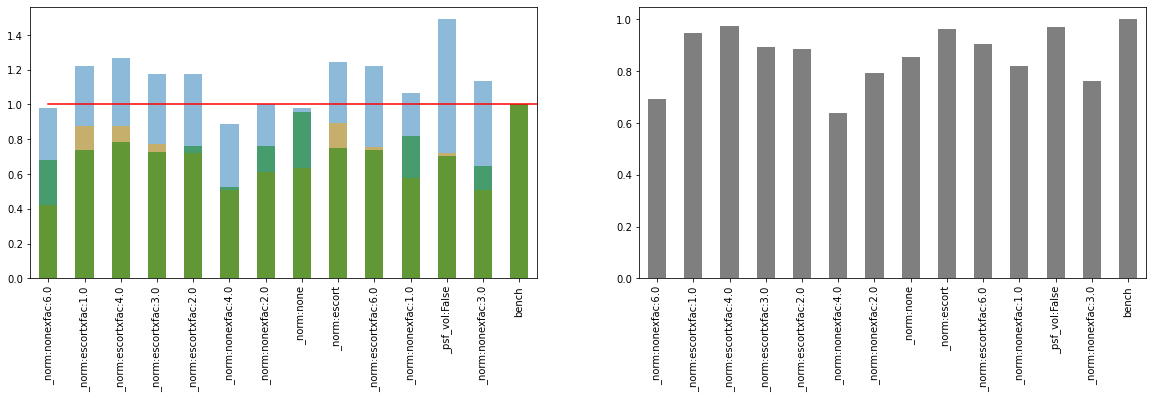

In [22]:
plt.figure(figsize=(20,5))
plt.subplot(121)
omega_df.loc['NN_blanks','150'].plot.bar(alpha =0.5)
omega_df.loc['NN_blanks','151'].plot.bar(alpha =0.5, color='orange')
omega_df.loc['NN_blanks','47'].plot.bar(alpha =0.5, color='green')
plt.plot([0,len(omega_df.columns)/2],[1,1], color='red')
plt.subplot(122)
omega_df.mean(level=1, axis=1).loc['NN_blanks'].plot.bar(alpha =0.5, color='black')

/tmp/ipykernel_25835/3954611050.py:8: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  omega_df.mean(level=1, axis=1).loc['NN_blanks'].plot.bar(alpha =0.5, color='black')


<AxesSubplot:>

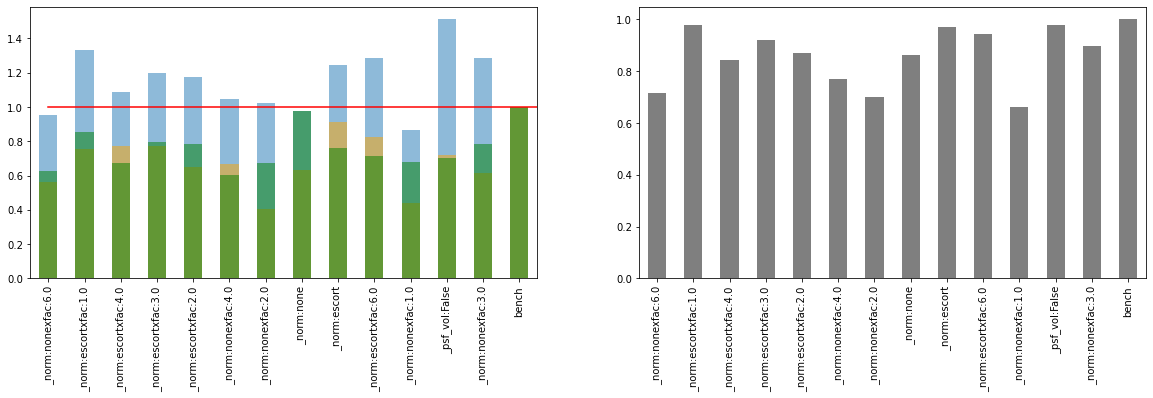

In [15]:
plt.figure(figsize=(20,5))
plt.subplot(121)
omega_df.loc['NN_blanks','150'].plot.bar(alpha =0.5)
omega_df.loc['NN_blanks','151'].plot.bar(alpha =0.5, color='orange')
omega_df.loc['NN_blanks','47'].plot.bar(alpha =0.5, color='green')
plt.plot([0,len(omega_df.columns)/2],[1,1], color='red')
plt.subplot(122)
omega_df.mean(level=1, axis=1).loc['NN_blanks'].plot.bar(alpha =0.5, color='black')

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning:

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().



<AxesSubplot:>

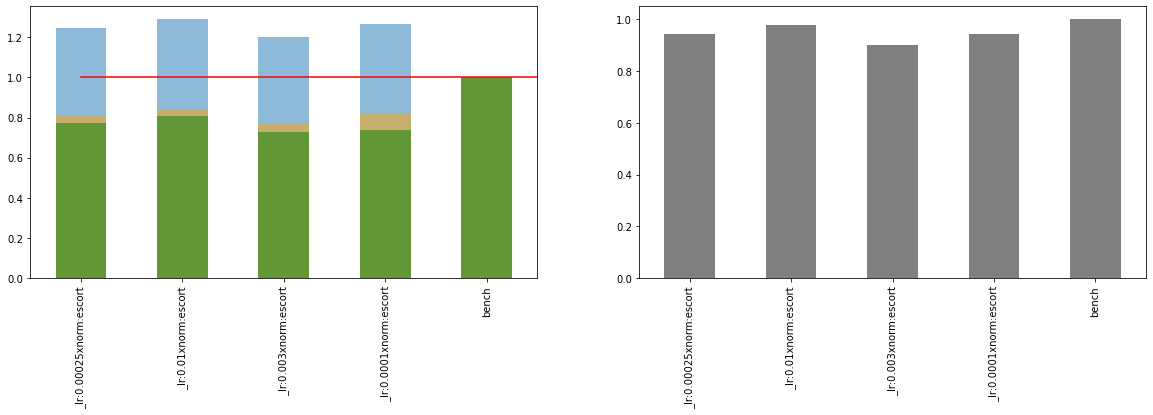

In [987]:
plt.figure(figsize=(20,5))
plt.subplot(121)
omega_df.loc['NN_blanks','150'].plot.bar(alpha =0.5)
omega_df.loc['NN_blanks','151'].plot.bar(alpha =0.5, color='orange')
omega_df.loc['NN_blanks','47'].plot.bar(alpha =0.5, color='green')
plt.plot([0,len(omega_df.columns)/2],[1,1], color='red')
plt.subplot(122)
omega_df.mean(level=1, axis=1).loc['NN_blanks'].plot.bar(alpha =0.5, color='black')

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning:

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().



<AxesSubplot:>

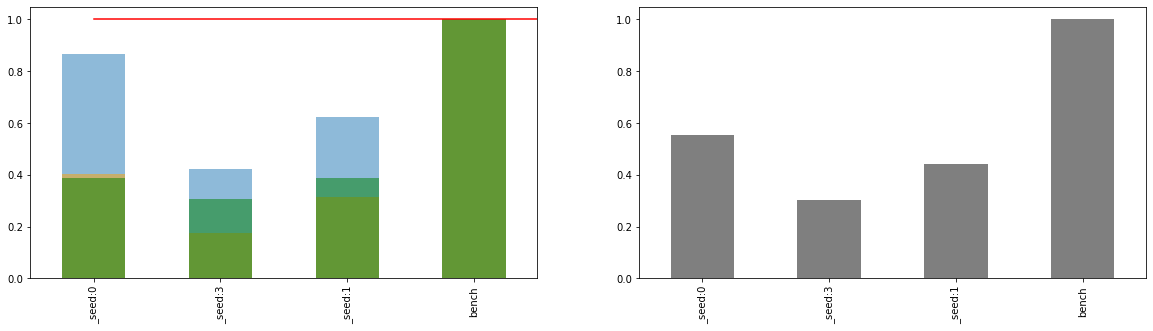

In [846]:
plt.figure(figsize=(20,5))
plt.subplot(121)
omega_df.loc['NN_blanks','150'].plot.bar(alpha =0.5)
omega_df.loc['NN_blanks','151'].plot.bar(alpha =0.5, color='orange')
omega_df.loc['NN_blanks','47'].plot.bar(alpha =0.5, color='green')
plt.plot([0,len(omega_df.columns)/2],[1,1], color='red')
plt.subplot(122)
omega_df.mean(level=1, axis=1).loc['NN_blanks'].plot.bar(alpha =0.5, color='black')

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning:

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().



<AxesSubplot:>

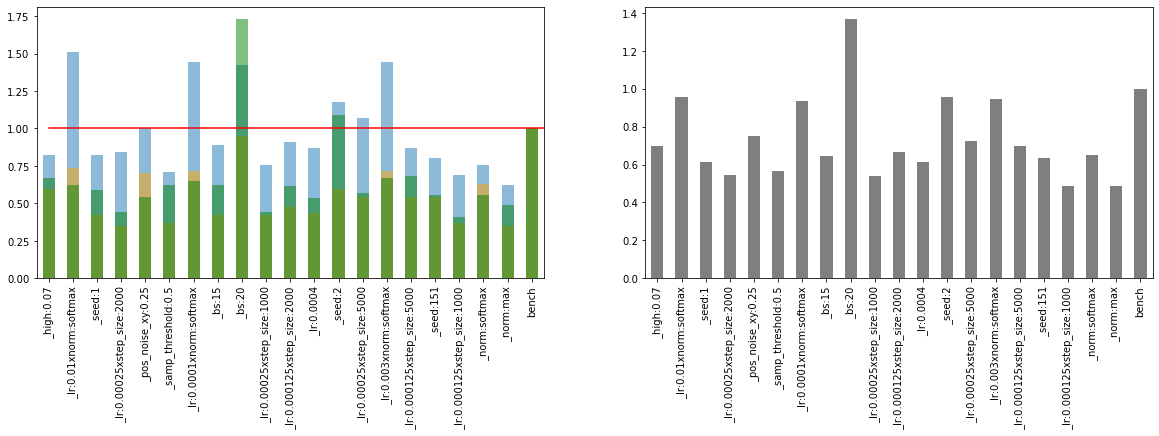

In [779]:
plt.figure(figsize=(20,5))
plt.subplot(121)
omega_df.loc['NN_blanks','150'].plot.bar(alpha =0.5)
omega_df.loc['NN_blanks','151'].plot.bar(alpha =0.5, color='orange')
omega_df.loc['NN_blanks','47'].plot.bar(alpha =0.5, color='green')
plt.plot([0,len(omega_df.columns)/2],[1,1], color='red')
plt.subplot(122)
omega_df.mean(level=1, axis=1).loc['NN_blanks'].plot.bar(alpha =0.5, color='black')

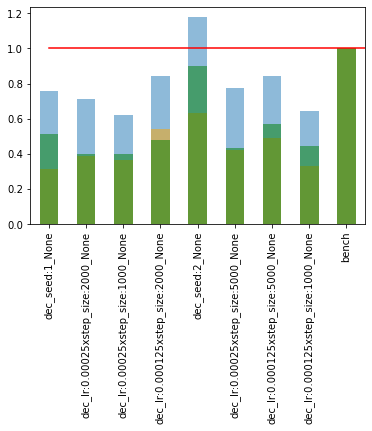

In [413]:
# plt.figure(figsize=(20,5))
omega_df.loc['NN_blanks','150'].plot.bar(alpha =0.5)
omega_df.loc['NN_blanks','151'].plot.bar(alpha =0.5, color='orange')
omega_df.loc['NN_blanks','47'].plot.bar(alpha =0.5, color='green')
plt.plot([0,len(omega_df.columns)/2],[1,1], color='red')

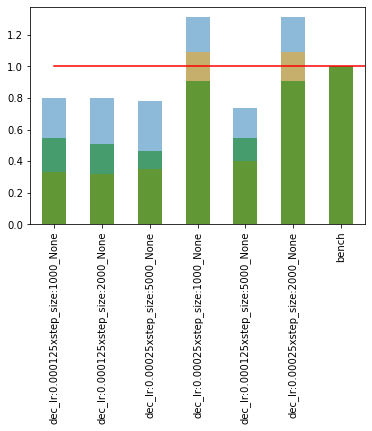

In [377]:
# plt.figure(figsize=(20,5))
omega_df.loc['NN_blanks','150'].plot.bar(alpha =0.5)
omega_df.loc['NN_blanks','151'].plot.bar(alpha =0.5, color='orange')
omega_df.loc['NN_blanks','47'].plot.bar(alpha =0.5, color='green')
plt.plot([0,len(omega_df.columns)/2],[1,1], color='red')

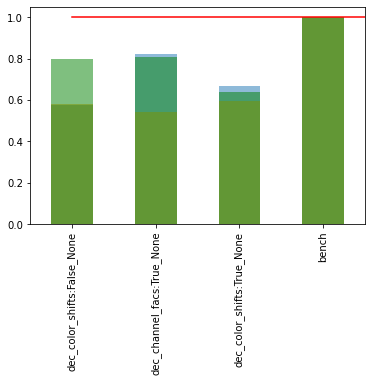

In [303]:
# plt.figure(figsize=(20,5))
omega_df.loc['NN_blanks','150'].plot.bar(alpha =0.5)
omega_df.loc['NN_blanks','151'].plot.bar(alpha =0.5, color='orange')
omega_df.loc['NN_blanks','47'].plot.bar(alpha =0.5, color='green')
plt.plot([0,len(omega_df.columns)/2],[1,1], color='red')

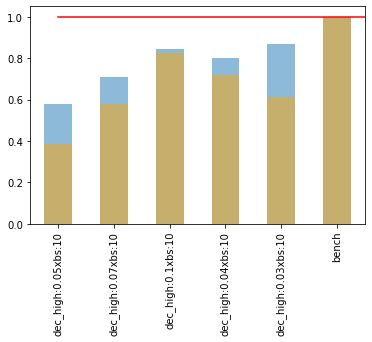

In [93]:
# plt.figure(figsize=(20,5))
omega_df.loc['NN_blanks','150'].plot.bar(alpha =0.5)
omega_df.loc['NN_blanks','151'].plot.bar(alpha =0.5, color='orange')
plt.plot([0,len(omega_df.columns)/2],[1,1], color='red')

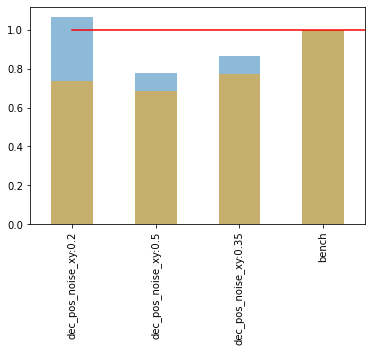

In [96]:
# plt.figure(figsize=(20,5))
omega_df.loc['NN_blanks','150'].plot.bar(alpha =0.5)
omega_df.loc['NN_blanks','151'].plot.bar(alpha =0.5, color='orange')
plt.plot([0,len(omega_df.columns)/2],[1,1], color='red')

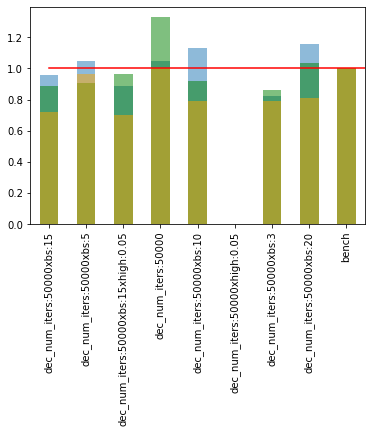

In [1142]:
# plt.figure(figsize=(20,5))
omega_df.loc['NN_blanks','150'].plot.bar(alpha =0.5)
omega_df.loc['NN_blanks','47'].plot.bar(alpha =0.5, color='green')
omega_df.loc['NN_blanks','151'].plot.bar(alpha =0.5, color='orange')
plt.plot([0,len(omega_df.columns)/2],[1,1], color='red')

In [978]:
res_df1 = df_dict['151']['_seed:3']

In [988]:
res_df2 = df_dict['151']['_lr:0.00025xnorm:escort']

In [989]:
res_df1['z'] = res_df1['z'] / 100
res_df2['z'] = res_df2['z'] / 100

In [990]:
res_df1 = sel_int_ch(res_df1, code_ref)
res_df2 = sel_int_ch(res_df2, code_ref)

In [991]:
res_df1['int_tot'] =  res_df1[[f'int_{i}' for i in range(4)]].values.astype('float32').sum(-1)
res_df2['int_tot'] =  res_df2[[f'int_{i}' for i in range(4)]].values.astype('float32').sum(-1)

In [922]:
res_single = remove_doublets(res_df)

In [992]:
_,matches,shift = matching(res_df1.nsmallest(40000, 'score'), res_df2.nsmallest(40000, 'score'), tolerance=500, print_res=True, allow_multiple_matches=False)

Recall: 0.874
Precision: 0.874
Jaccard: 77.604
RMSE_vol: 25.059
Eff_3d: 74.338
FN: 5044.0 FP: 5044.0
Num. matches: 34956.000
Shift: 5.73,-3.57,-0.55


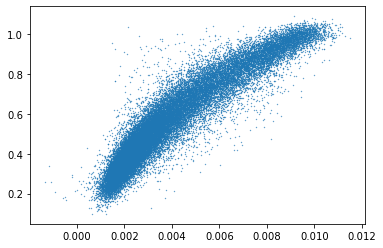

In [994]:
plt.scatter(matches['z_tar'],matches['z_pred'], s=0.1)
# plt.plot([0,25],[0,25], color='red')

In [864]:
_,matches,shift = matching(bench_151, res_df1.nsmallest(36500, 'score'), tolerance=500, print_res=True, allow_multiple_matches=False)

Recall: 0.072
Precision: 0.072
Jaccard: 3.751
RMSE_vol: 65.347
Eff_3d: -1.643
FN: 33826.0 FP: 33862.0
Num. matches: 2638.000
Shift: 0.17,1.73,-37.51


In [851]:
_,matches,shift = matching(istd_151.nlargest(50000, 'quality'), res_df.nsmallest(50000, 'score'), tolerance=500, print_res=True, allow_multiple_matches=False)

Recall: 0.002
Precision: 0.002
Jaccard: 0.109
RMSE_vol: 352.061
Eff_3d: -102.398
FN: 49891.0 FP: 49891.0
Num. matches: 109.000
Shift: -1.41,-14.39,1.20


In [1150]:
_,matches,shift = matching(res_df, res_df2, tolerance=300, print_res=True, allow_multiple_matches=False)

Recall: 0.740
Precision: 0.855
Jaccard: 65.702
RMSE_vol: 35.131
Eff_3d: 61.466
FN: 30852.0 FP: 14923.0
Num. matches: 87688.000
Shift: -0.22,-0.05,-0.21


In [1151]:
len(matches)

87688

In [858]:
matches['score_pred'] = np.array(matches['score_pred'].values, dtype=np.float32)
matches['gene'] = matches['gene_pred']

36464 36500


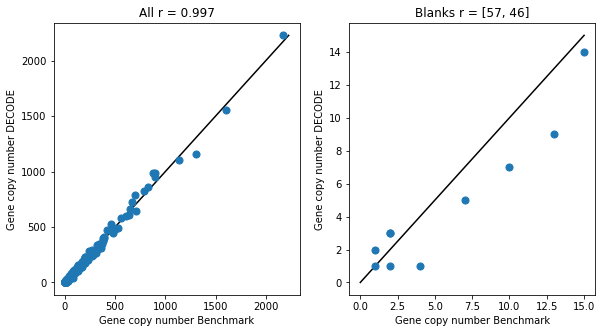

In [996]:
plot_gene_panels(res_df2.nsmallest(36500, 'score'), bench_151, targets)

36464 36500


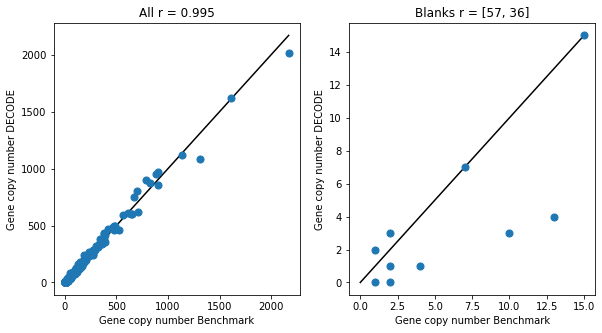

In [497]:
plot_gene_panels(istd_151.nlargest(36500, 'quality'), bench_151, targets)

In [503]:
len(targets)

252

In [997]:
fns = res_df2.loc[~res_df2['loc_idx'].isin(matches['loc_idx_tar'])]
tps = res_df2.loc[res_df2['loc_idx'].isin(matches['loc_idx_tar'])]
fps = res_df.loc[~res_df['loc_idx'].isin(matches['loc_idx_pred'])]
print(tps['gene'].str.contains('Blank').sum()/len(tps)*100)
print(fns['gene'].str.contains('Blank').sum()/len(fns)*100)
print(fps['gene'].str.contains('Blank').sum()/len(fps)*100)

0.233849751534639
0.3033268101761253
0.22388059701492538


In [1030]:
fns = istd_151.loc[~istd_151['loc_idx'].isin(matches['loc_idx_tar'])]
tps = istd_151.loc[istd_151['loc_idx'].isin(matches['loc_idx_tar'])]
fps = res_df.loc[~res_df['loc_idx'].isin(matches['loc_idx_pred'])]
print(tps['gene'].str.contains('Blank').sum()/len(tps)*100)
print(fns['gene'].str.contains('Blank').sum()/len(fns)*100)
print(fps['gene'].str.contains('Blank').sum()/len(fps)*100)

0.11387163561076605
2.4536775421586414
1.5951352780470611


In [705]:
gene_counts = DF(data=None, index=targets)
gene_counts['dec'] = res_sub_s.groupby('gene')['gene'].count()
gene_counts['ist'] = bench_df.groupby('gene')['gene'].count()
gene_counts['tps'] = tps.groupby('gene')['gene'].count()
gene_counts['fps'] = fps.groupby('gene')['gene'].count()
gene_counts['fns'] = fns.groupby('gene')['gene'].count()
gene_counts = gene_counts.fillna(0)

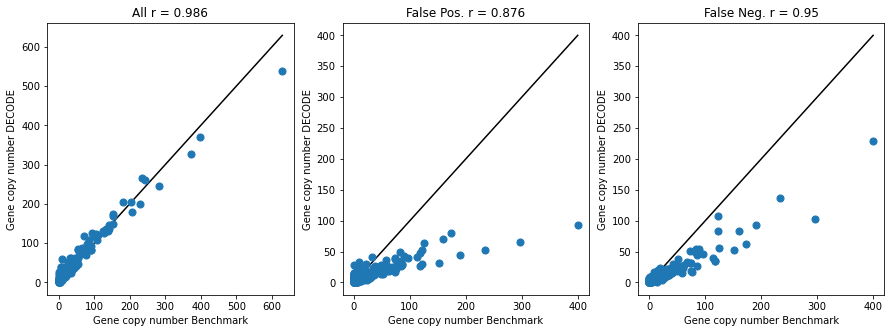

In [706]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plot_gene_numbers(gene_counts['ist'].values, gene_counts['dec'].values, 'All', log=False)
plt.subplot(132)
plot_gene_numbers(gene_counts['tps'].values, gene_counts['fps'].values, 'False Pos.', log=False)
plt.subplot(133)
plot_gene_numbers(gene_counts['tps'].values, gene_counts['fns'].values, 'False Neg.', log=False)

Text(0.5, 1.0, 'Corr. 0.954')

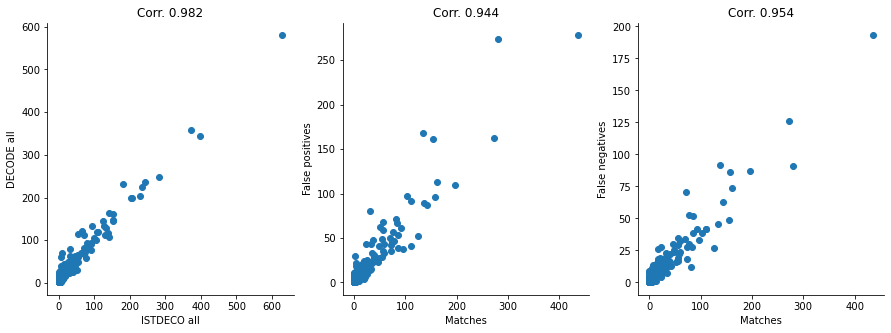

In [676]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.scatter(gene_counts['ist'].values, gene_counts['dec'].values)
plt.plot([0,0],[len(gene_counts['ist'].values),len(gene_counts['dec'].values)])
sns.despine()
plt.xlabel('ISTDECO all')
plt.ylabel('DECODE all')
plt.title('Corr. ' + str(np.corrcoef(gene_counts['ist'].values, gene_counts['dec'].values)[0,1])[:5])
plt.subplot(132)
plt.scatter(gene_counts['tps'].values, gene_counts['fps'].values)
sns.despine()
plt.xlabel('Matches')
plt.ylabel('False positives')
plt.title('Corr. ' + str(np.corrcoef(gene_counts['tps'].values, gene_counts['fps'].values)[0,1])[:5])
plt.subplot(133)
plt.scatter(gene_counts['tps'].values, gene_counts['fns'].values)
sns.despine()
plt.xlabel('Matches')
plt.ylabel('False negatives')
plt.title('Corr. ' + str(np.corrcoef(gene_counts['tps'].values, gene_counts['fns'].values)[0,1])[:5])


In [828]:
par_dict = {}
par_dict['istdeco'] = [istd_151, 'quality', False]
for i,k in enumerate(df_dict['151']):
#     if 'dec_' in k and '151' in k:
    if len(df_dict['151'][k]) > 0:
        par_dict[k] = [df_dict['151'][k], 'score', True]
    #         par_dict[k+'_s'] = [remove_doublets(df_dict[k].nsmallest(50000,'comb_sig')), 'comb_sig', True]

roc_dict = {}
for k in par_dict:
    x, y = make_roc(*par_dict[k], n_max=80000)
    roc_dict[k] = [x, y]

In [998]:
par_dict = {}
par_dict['istdeco'] = [istd_151, 'quality', False]
par_dict['1'] = [res_df1, 'prob', False]
par_dict['2'] = [res_df2, 'prob', False]

roc_dict = {}
for k in par_dict:
    x, y = make_roc(*par_dict[k], n_max=80000)
    roc_dict[k] = [x, y]

In [999]:
df = pd.DataFrame(columns=roc_dict.keys())
df['x'] = roc_dict[df.keys()[0]][0]
for k in roc_dict.keys():
    df[k] = roc_dict[k][1]

In [1000]:
fig = px.line(df, x="x", y=list(roc_dict.keys()), range_y=[0,150], range_x=[0,80000], labels={"x": "Number genes","value":'Number blanks'})
fig.show()

KeyError: 'dec_lr:0.000125xstep_size:1000_None_151'

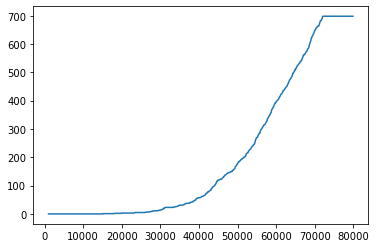

In [831]:
plt.plot(df['x'], df['istdeco'], label='istdeco')
plt.plot(df['x'], df['dec_lr:0.000125xstep_size:1000_None_151'], label='DECODE')
plt.plot([0,45000], [57,57], label='Reference')
plt.plot([36500,36500], [0,100], color='green')
plt.xlim(0,45000)
plt.ylim(0,100)
plt.xlabel('Number transcripts')
plt.xlabel('Number blanks')
plt.legend()

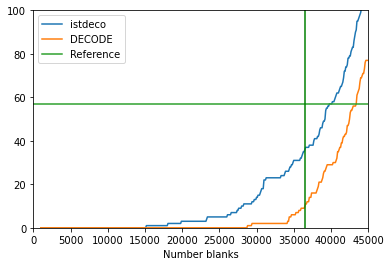

In [722]:
plt.plot(df['x'], df['istdeco'], label='istdeco')
plt.plot(df['x'], df['_seed:3'], label='DECODE')
plt.plot([0,45000], [57,57], label='Reference')qq
plt.plot([36500,36500], [0,100], color='green')
plt.xlim(0,45000)
plt.ylim(0,100)
plt.xlabel('Number transcripts')
plt.xlabel('Number blanks')
plt.legend()

In [569]:
res_df = df_dict['dec_enabled:Truexint_inf:per_channelxchannel_shifts:Truexchannel_facs:Truexn_foci_avg:1xseed:2']
int_m = [f'int_{i}' for i in range(4)]
int_s = [f'int_sig_{i}' for i in range(4)]
res_df['int_tot'] = res_df.loc[:,int_m].values.sum(-1)
res_df['int_sig_tot'] = res_df.loc[:,int_s].values.sum(-1)


metrics = ['comb_sig','int_tot','int_sig_tot', 'prob','zm']
bins = [np.linspace(0,1.5,31), np.linspace(0,50,31), np.linspace(0,20,31), np.linspace(0.4,1,31), np.linspace(0,100.,31)]
plt.figure(figsize=(20,5))
for i in range(len(metrics)):
    plt.subplot(1,len(metrics),i+1)
    _=plt.hist(res_df[~res_df['gene'].str.contains('Blank')][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='gene matches')
    _=plt.hist(res_df[res_df['gene'].str.contains('Blank')][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='blank matches')
    plt.title(metrics[i])

KeyError: 'dec_enabled:Truexint_inf:per_channelxchannel_shifts:Truexchannel_facs:Truexn_foci_avg:1xseed:2'

In [299]:
res_df = df_dict['dec_enabled:Truexint_inf:per_channelxchannel_shifts:Truexchannel_facs:Truexn_foci_avg:1xseed:2'].nsmallest(10000, 'comb_sig')

In [290]:
code_cols = [plt.get_cmap('gist_ncar')(x) for x in np.linspace(0.,1.,140)]

In [291]:
import mpld3
from mpld3 import plugins

In [663]:
res_sub = df_dict['dec_psf_noise:0.0xrate_fac:3.0'].nsmallest(17000, 'comb_sig')
# res_sub = df_dict['dec_min_int_sig:0.0xint_fac:0.1'].nsmallest(15000, 'code_err')
ist_sub = istdeco_df.nlargest(15000, 'quality')
bench_sub = bench_df.nlargest(13800, 'total_magnitude')

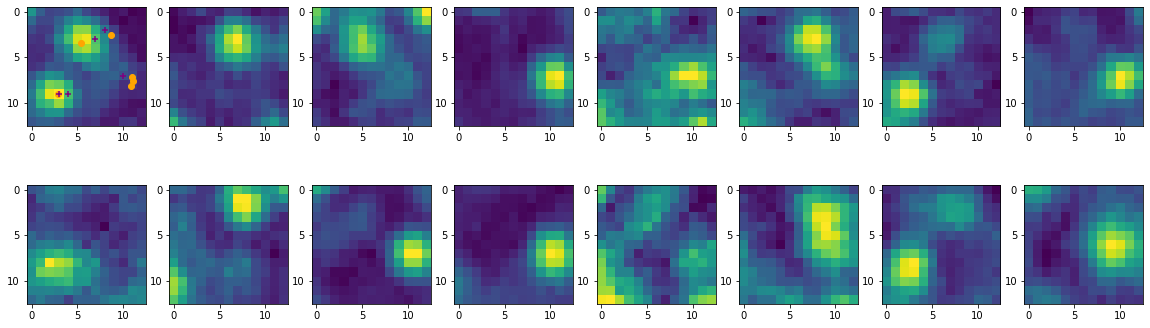

In [664]:
vol, crop = extract_roi(img_stack[None], torch.IntTensor([514,740,0]), 6, 8)

res_crop = crop_df(nm_to_px(res_sub), crop)
ist_crop = crop_df(nm_to_px(ist_sub), crop)

plt.figure(figsize=(20,6))
for i in range(16):
    plt.subplot(2,8,i+1)
    plt.imshow(vol[0,i])
    
    if not i:
        plt.scatter(res_crop['x'],res_crop['y'],color='orange')
        plt.scatter(ist_crop['x'],ist_crop['y'],color='purple', marker='+')

In [810]:
img_stack = read_MOp_tiff(base_path+'/datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/aligned_images47.tif')[:,:,:,:,:]

In [657]:
img_stack.shape

torch.Size([1, 22, 7, 2048, 2048])

In [658]:
from decode_fish.funcs.dataset import GaussianSmoothing
filt = GaussianSmoothing(11, device='cpu')
img_filt = filt(img_stack)
img_stack -= img_filt

In [799]:
df_dict['47'].keys()

dict_keys(['_lr:0.01xnorm:escort', '_lr:0.0001xnorm:escort', '_lr:0.003xnorm:escort', '_lr:0.00025xnorm:escort'])

In [800]:
# res_df = df_dict['dec_enabled:Truexint_inf:per_channelxchannel_shifts:Truexchannel_facs:Truexn_foci_avg:1xseed:2'].nsmallest(10000, 'comb_sig')
# res_df = df_dict['dec_enabled:Truexint_inf:per_channelxchannel_shifts:Truexchannel_facs:Truexn_foci_avg:1xseed:2'].nsmallest(10000, 'comb_sig')
res_df = df_dict['47']['_lr:0.00025xnorm:escort']#.nsmallest(30000, 'comb_sig')
# res_df = sel_int_ch(res_df, code_ref)

In [801]:
res_df['int_tot'] =  res_df[[f'int_{i}' for i in range(4)]].values.astype('float32').sum(-1)

In [802]:
def extract_roi(beads: torch.Tensor, coordinates, size_xy=5):
    res = []
    
    x, y, z = coordinates
    crop = np.s_[:,z, int(y-size_xy): int(y+size_xy+1), int(x-size_xy): int(x+size_xy+1)]
    single_bead = beads[crop]
        
    return single_bead, crop

In [803]:
z_vols = [[] for _ in range(20)]

In [804]:
int_keys = [f'int_{i}' for i in range(22)]

In [811]:
for i in tqdm(range(len(res_df))):
    b_loc = nm_to_px(res_df.iloc[i])
    vol, crop = extract_roi(img_stack[0], torch.IntTensor(np.array(b_loc.loc[['x','y','frame_idx']].values, dtype='float32')), 6)
    if vol.shape == torch.Size([22, 13, 13]):
        ints = b_loc[int_keys].values.astype('float32')
        volm = vol/ints[:,None,None]
        volm = cpu(volm[code_ref[b_loc['code_inds']].nonzero()[0]])
        z = np.clip(b_loc['z'],0,100)
        z_vols[int(b_loc['zm']/5)].append(volm)

100%|█████████████████████████████████████████████████████| 77226/77226 [01:50<00:00, 701.39it/s]


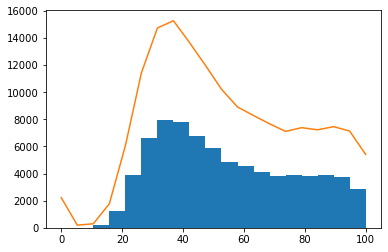

In [812]:
plt.hist(res_df['z'], bins=np.linspace(0,100,20))
plt.plot(np.linspace(0,100,20), [len(z) for z in z_vols])

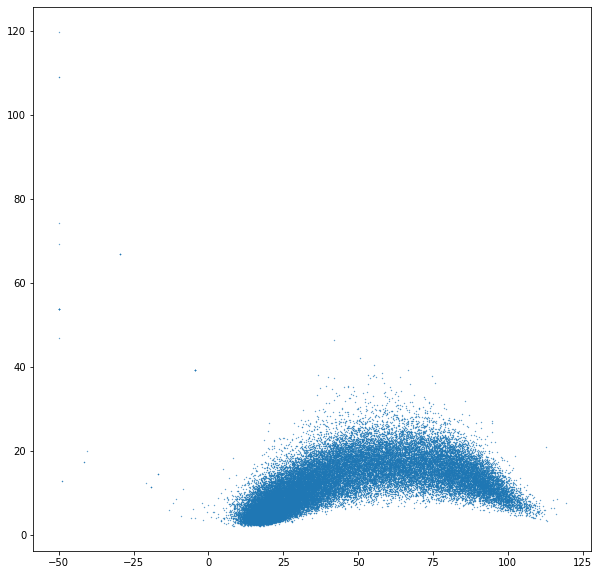

In [872]:
plt.figure(figsize=[10,10])
plt.scatter(res_df['z'], res_df['z_sig'], s=0.1)

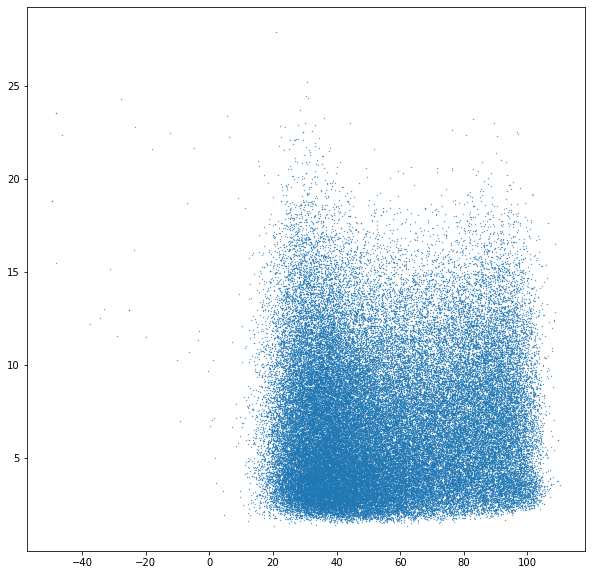

In [874]:
plt.figure(figsize=[10,10])
plt.scatter(res_df['z'], res_df['int_tot'], s=0.1)

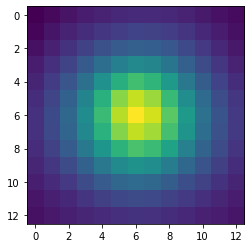

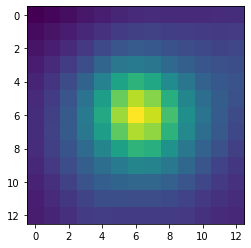

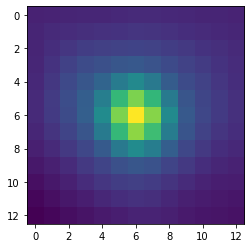

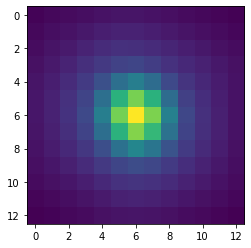

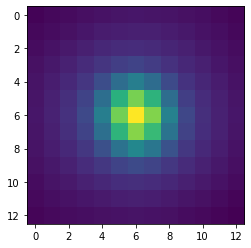

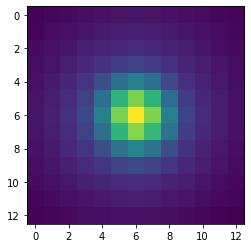

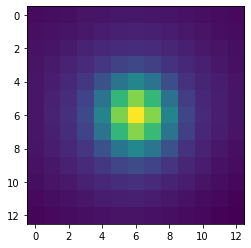

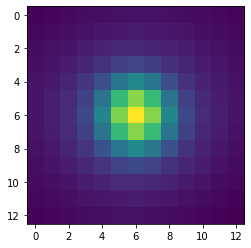

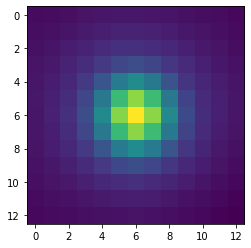

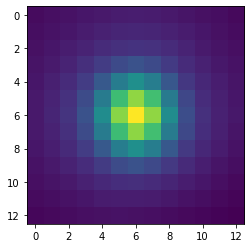

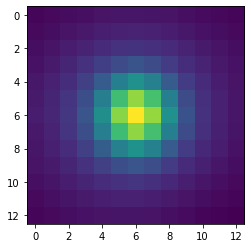

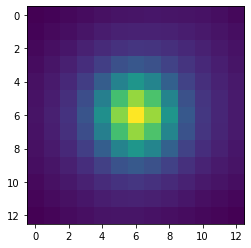

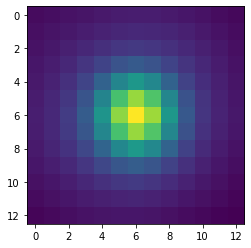

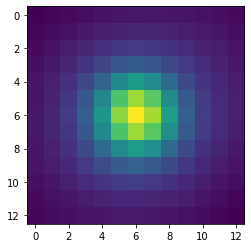

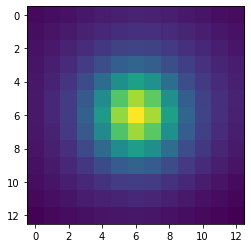

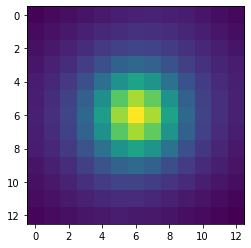

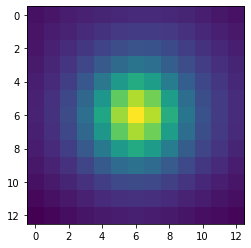

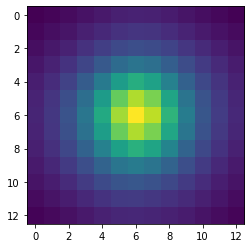

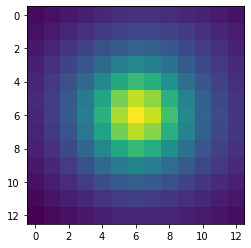

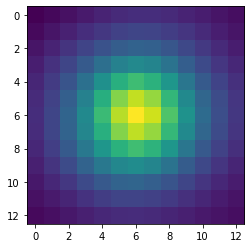

In [815]:
psf_vol = []
for i in range(len(z_vols)):
    mvol = np.stack(z_vols[i])
    mvol = mvol.reshape(-1, mvol.shape[-2], mvol.shape[-1])
    psf_vol.append(mvol.mean(0)/mvol.mean(0).max())
    plt.imshow(mvol.mean(0))
    plt.show()

In [816]:
psf_vol = np.stack(psf_vol)

(<Figure size 1139.82x1096.62 with 6 Axes>,
 [<AxesSubplot:ylabel='y'>,
  <AxesSubplot:xlabel='x', ylabel='z'>,
  <AxesSubplot:xlabel='z'>])

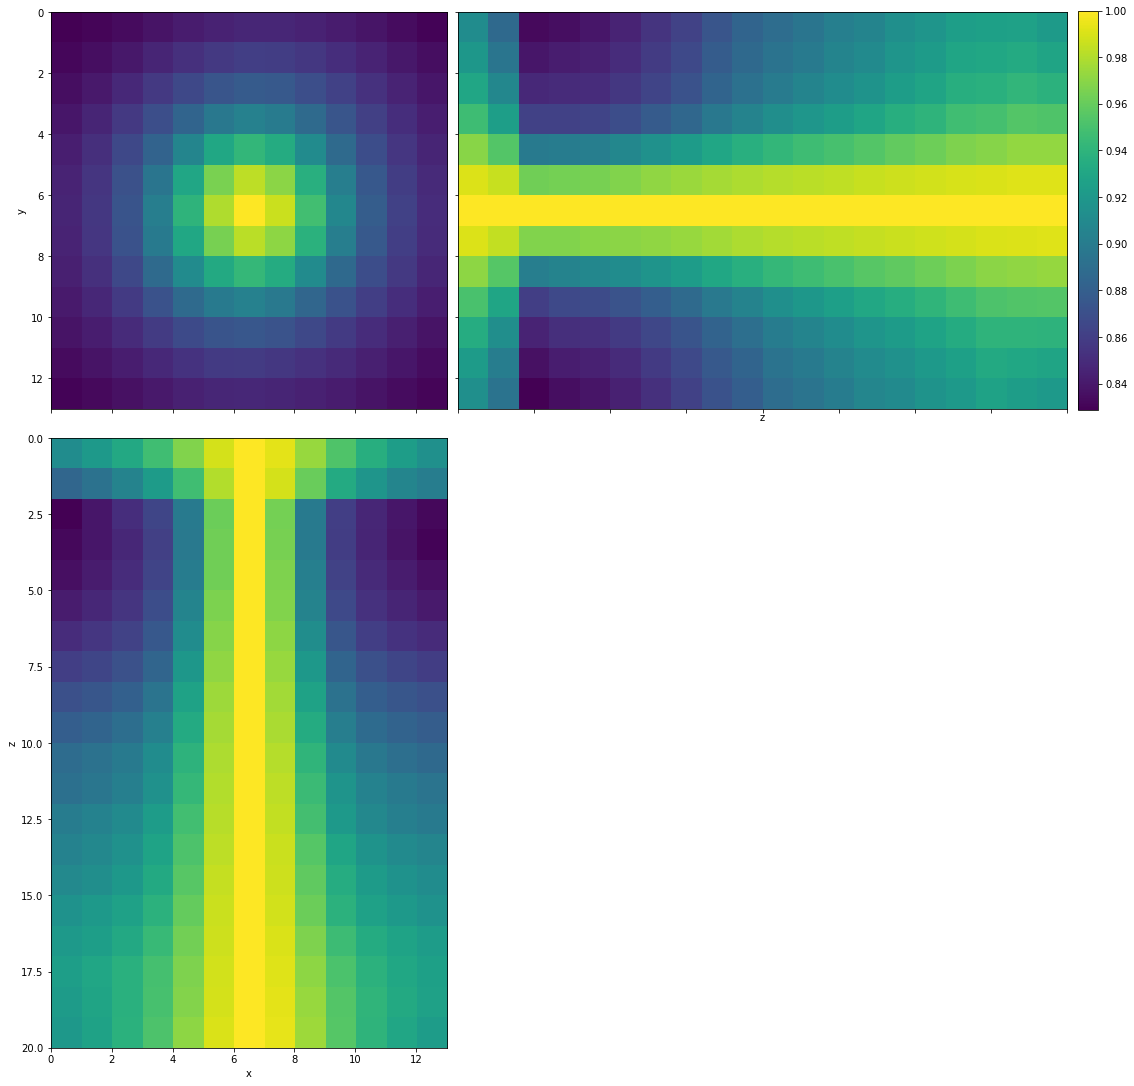

In [817]:
plot_3d_projections(psf_vol)

21392


(600.0, 750.0)

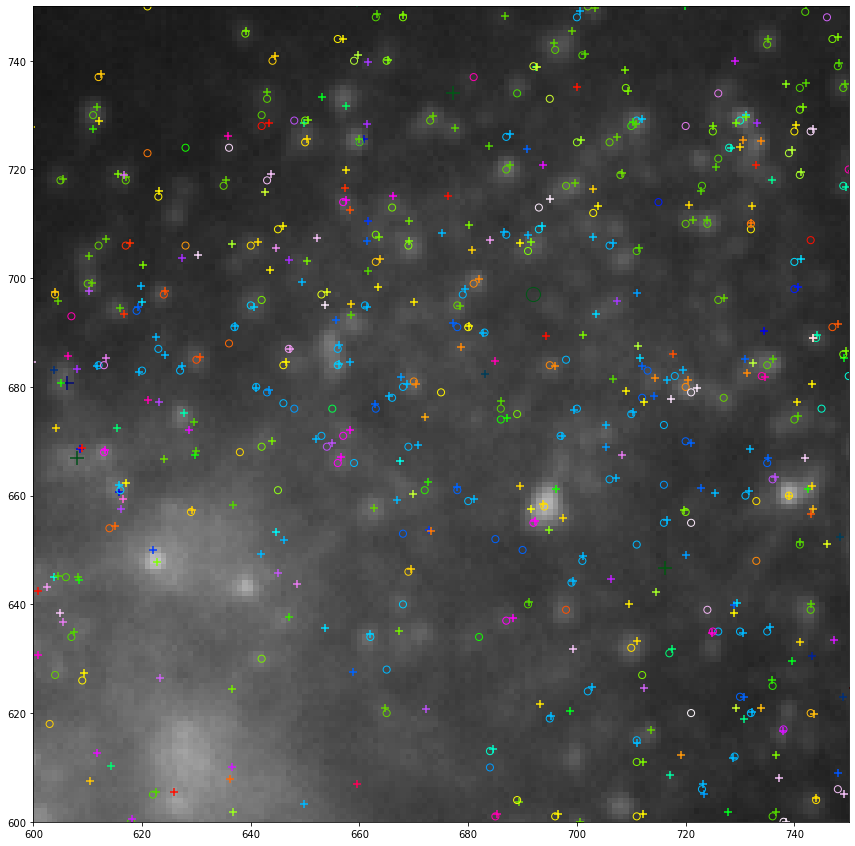

In [63]:
ind = 0
img = load_tiff_image(image_paths[ind])
preds_px = nm_to_px(res_single)#[res_df['gene']!='MALAT1']
bench_px = nm_to_px(ist_sub)#[bench_df['gene']!='MALAT1']
print(len(preds_px))
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(img[0,0], cmap='gray')

for i in range(len(targets)):
    
    preds_sub = preds_px[preds_px['code_inds'] == i]
    bench_sub = bench_px[bench_px['code_inds'] == i]
    
    size = 200. if 'Blank' in targets[i] else 50.

    ax.scatter(bench_sub['x'],bench_sub['y'], color=code_cols[i], s=size, marker='o', facecolor='none')
    ax.scatter(preds_sub['x'],preds_sub['y'], color=code_cols[i], s=size, marker='+')

ax.set_xlim(600,750)
ax.set_ylim(600,750)

# plugins.connect(fig, plugins.MousePosition(fontsize=14))
# mpld3.display()

In [409]:
def extract_roi(beads: torch.Tensor, coordinates, size_xy=5, size_z=10):
    res = []
    
    x, y, z = coordinates
    crop = np.s_[:,int(z):int(z+1), int(y-size_xy): int(y+size_xy+1), int(x-size_xy): int(x+size_xy+1)]
    single_bead = beads[crop]
        
    return single_bead, crop

# Analyze blanks

26


,loc_idx,frame_idx,code_inds,x,y,z,prob,x_sig,y_sig,z_sig,...,int_1,int_2,int_3,int_sig_0,int_sig_1,int_sig_2,int_sig_3,zm,int_tot,int_sig_tot
28421,28421,0,243,383.26723,68.88303,2.376363,0.658758,17.744606,23.340118,8.481233,...,5.209935,6.694495,8.023641,1.996939,1.568243,3.390814,3.319344,37.63626,26.435554,10.275341


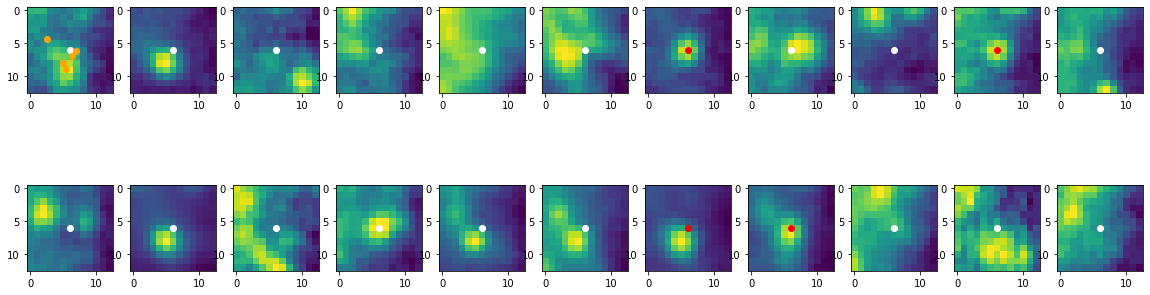

In [422]:
# Random predictions 
res_sub = res_df.nsmallest(20000, 'comb_sig')
# Random blank 
sub = res_sub[res_sub['gene'].str.contains('Blank')]

ind = np.random.randint(0, len(sub))
print(ind)

b_loc = nm_to_px(sub.iloc[ind])
display(DF(b_loc).T)
vol, crop = extract_roi(img_stack, torch.IntTensor(np.array(b_loc.loc[['x','y','z']].values, dtype='float32')), 6, 8)

res_crop = crop_df(nm_to_px(res_sub), crop)
bench_crop = crop_df(nm_to_px(bench_df), crop)

plt.figure(figsize=(20,6))
for i in range(22):
    plt.subplot(2,11,i+1)
    plt.imshow(vol[i,0])
    color = 'red' if code_ref[list(targets).index(b_loc['gene'])][i] else 'white'
    plt.scatter([6],[6], color=color)
    
#     plt.title(str(np.round(b_loc[f'int_{i}'], 3)) + ' +- ' + str(np.round(b_loc[f'int_sig_{i}'], 3)))
    
    if not i:
        plt.scatter(res_crop['x'],res_crop['y'],color='orange')
        plt.scatter(bench_crop['x'],bench_crop['y'],color='purple', marker='+')

In [677]:
fn_inds = fns['loc_idx'].values

In [678]:
len(res_df)

15020

In [679]:
res_sub = res_df.nsmallest(10000, 'comb_sig')

,loc_idx,x,y,z,gene,frame_idx,code_inds
5894569,5894569,90.023502,729.022581,2.304147,Pdgfc,0,152


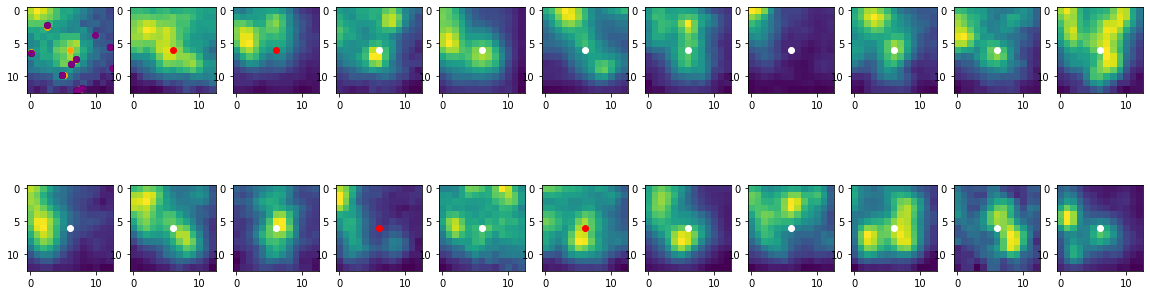

In [681]:
ind = np.random.randint(0, len(fn_inds))
ind = fn_inds[ind]

b_loc = nm_to_px(bench_df[bench_df['loc_idx'] == ind], px_size_zyx=[120.0, 100.0, 100.0]).iloc[0]

display(DF(b_loc).T)
vol, crop = extract_roi(img_stack, torch.IntTensor(np.array(b_loc.loc[['x','y','z']].values, dtype='float32')), 6, 8)

cropb = crop_df(nm_to_px(bench_df, px_size_zyx=[120.0, 100.0, 100.0]), crop)
cropr = crop_df(nm_to_px(res_sub), crop)
cropf = crop_df(nm_to_px(res_df), crop)

plt.figure(figsize=(20,6))
for i in range(22):
    plt.subplot(2,11,i+1)
    plt.imshow(vol[i,0])
    color = 'red' if code_ref[list(targets).index(b_loc['gene'])][i] else 'white'
    plt.scatter([6],[6], color=color)
    
    if not i:
        plt.scatter(cropb['x'],cropb['y'],color='orange')
        plt.scatter(cropr['x'],cropr['y'],color='black')
        plt.scatter(cropf['x'],cropf['y'],color='purple')

In [545]:
cropb

,loc_idx,x,y,z,gene,frame_idx,code_inds
5911774,5911774,6.497235,6.030876,0.760369,Olfm3,0,144


In [382]:
res_df = remove_doublets(df_dict['dec_num_iters:100000xenabled:False'])

In [383]:
keys = ['x_sig','y_sig','z_sig','prob','int_0', 'int_1', 'int_2', 'int_3', 'int_sig_0', 'int_sig_1', 'int_sig_2', 'int_sig_3', 'zm']
res_df['class'] = res_df['gene'].str.contains('Blank')*1

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [384]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

X = np.concatenate([res_df.nsmallest(10000,'comb_sig')[keys].values, res_df[res_df['class'] == 1][keys].values])
y = np.concatenate([res_df.nsmallest(10000,'comb_sig')['class'].values, res_df[res_df['class'] == 1]['class'].values])
 
clf = LogisticRegression(random_state=0,max_iter=10000).fit(X, y)

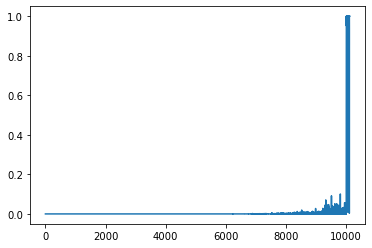

In [385]:
plt.plot(clf.predict_proba(X)[:,1])

In [386]:
# res_df = remove_doublets(df_dict['dec_num_iters:100000xenabled:False'])
res_df = remove_doublets(df_dict['dec_start_mic:30000xpsf_vol:Truextheta_par:Truexlr:0.0004'])
X = res_df[keys]

In [387]:
res_df['score'] = clf.predict_proba(X)[:,1]

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



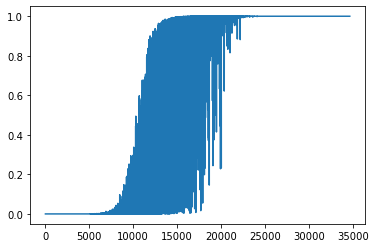

In [388]:
plt.plot(res_df.nsmallest(50000, 'comb_sig')['score'].values)

In [821]:
par_dict = {}

par_dict['comb_sig'] = [res_df, 'comb_sig', True]
par_dict['score'] = [res_df, 'score', True]

In [822]:
roc_dict = {}
for k in par_dict:
    x, y = make_roc(*par_dict[k], n_max=50000)
    roc_dict[k] = [x, y]

In [823]:
df = pd.DataFrame(columns=roc_dict.keys())
df['x'] = roc_dict[df.keys()[0]][0]
for k in roc_dict.keys():
    df[k] = roc_dict[k][1]

In [824]:
fig = px.line(df, x="x", y=list(roc_dict.keys()), range_y=[0,100], range_x=[0,50000], labels={"x": "Number genes","value":'Number blanks'})
fig.show()

In [378]:
df_dict['151'].keys()

dict_keys(['dec_lr:0.000125xstep_size:1000_None_151', 'dec_lr:0.000125xstep_size:2000_None_151', 'dec_lr:0.00025xstep_size:5000_None_151', 'dec_lr:0.00025xstep_size:1000_None_151', 'dec_lr:0.000125xstep_size:5000_None_151', 'dec_lr:0.00025xstep_size:2000_None_151'])

In [379]:
res_df = df_dict['151']['dec_lr:0.000125xstep_size:1000_None_151'].nsmallest(35000, 'score')

In [875]:
def sel_int_ch(res_df, codebook):
    
    int_m = [f'int_{i}' for i in range(codebook.shape[1])]
    int_s = [f'int_sig_{i}' for i in range(codebook.shape[1])]
    
    int_arr = res_df.loc[:,int_m].values
    int_sig = res_df.loc[:,int_s].values
    
    int_arr[codebook[res_df['code_inds'].values] == 0] = 0.
    int_sig[codebook[res_df['code_inds'].values] == 0] = 0.
    
#     print(int_arr.shape)
    
    ret_df = res_df.drop(columns=int_m)
    ret_df = ret_df.drop(columns=int_s)
    
    ret_df[int_m] = int_arr
    ret_df[int_s] = int_sig

    return ret_df

In [970]:
int_arr = sel_int_ch(res_df2.nsmallest(35000,'score'), code_ref)[[f'int_{i}' for i in range(code_ref.shape[1])]].values

In [971]:
int_arr.shape

(35000, 22)

In [972]:
means2 = [int_arr[:,i].sum()/(int_arr[:,i] != 0).sum() for i in range(22)]

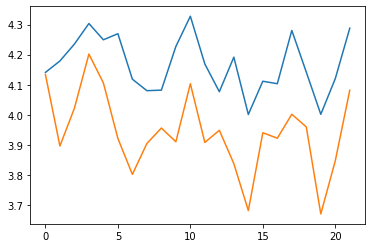

In [973]:
plt.plot(means2)
plt.plot(means3)

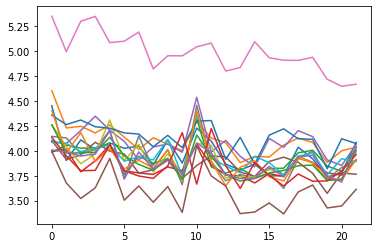

In [461]:
for k in df_dict['151'].keys():
    res_df = df_dict['151'][k].nsmallest(35000, 'score')    
    int_arr = sel_int_ch(res_df.nsmallest(50000,'score'), code_ref)[[f'int_{i}' for i in range(code_ref.shape[1])]].values
    means = [int_arr[:,i].sum()/(int_arr[:,i] != 0).sum() for i in range(22)]
    plt.plot(means, label=k)
# plt.legend()

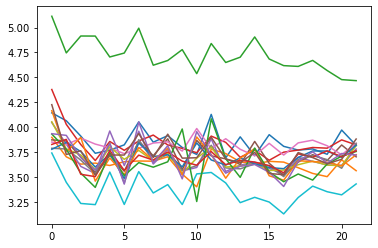

In [462]:
for k in df_dict['150'].keys():
    res_df = df_dict['150'][k].nsmallest(30000, 'score')    
    int_arr = sel_int_ch(res_df, code_ref)[[f'int_{i}' for i in range(code_ref.shape[1])]].values
    means = [int_arr[:,i].sum()/(int_arr[:,i] != 0).sum() for i in range(22)]
    plt.plot(means, label=k)
# plt.legend()

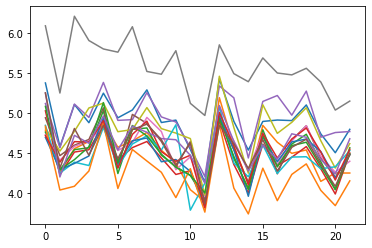

In [463]:
for k in df_dict['47'].keys():
    res_df = df_dict['47'][k].nsmallest(30000, 'score')    
    int_arr = sel_int_ch(res_df, code_ref)[[f'int_{i}' for i in range(code_ref.shape[1])]].values
    means = [int_arr[:,i].sum()/(int_arr[:,i] != 0).sum() for i in range(22)]
    plt.plot(means, label=k)
# plt.legend()

In [893]:
res_df2

,loc_idx,frame_idx,code_inds,x,y,z,prob,x_sig,y_sig,z_sig,...,int_sig_18,int_19,int_sig_19,int_20,int_sig_20,int_21,int_sig_21,gene,zm,score
0,2,0,1,171089.250,165031.330,97.915344,0.504862,20.514560,18.683390,7.342714,...,0.636603,0.703876,0.489079,3.082944,0.792615,4.721849,0.755786,1810046K07Rik,97.915344,0.549186
1,3,0,2,116737.280,15030.066,26.141537,1.000000,30.931070,32.614150,19.693487,...,1.612851,2.296247,0.912062,3.055187,1.164243,7.588719,2.938631,5031425F14Rik,26.141537,0.520093
2,7,0,2,185065.030,63442.945,84.295830,0.529371,28.899155,39.141050,16.723677,...,0.579839,0.598403,0.368664,1.852078,1.241420,4.236682,0.530626,5031425F14Rik,84.295830,0.768136
3,21,0,3,111799.370,55095.656,78.479454,0.713383,41.903380,23.382769,20.022266,...,2.145799,4.644685,1.963113,4.205289,1.773098,1.946853,0.954738,5730522E02Rik,78.479454,0.713115
4,24,0,3,103121.590,177002.620,88.787370,0.641441,27.545973,21.861172,8.724233,...,0.731137,4.586737,0.637230,0.953689,0.434744,1.914448,0.522346,5730522E02Rik,88.787370,0.559447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43380,71451,6,248,15372.030,123082.555,72.120026,0.509959,23.569070,23.460297,21.738350,...,1.061068,1.259103,0.693061,1.396581,0.618376,6.660366,2.322591,Blank-7,72.120026,0.689366
43381,71496,6,249,99062.760,165804.050,39.418655,0.606441,22.090633,10.978888,21.144314,...,0.269147,0.697618,0.398861,0.491663,0.243462,0.393896,0.184785,Blank-8,39.418655,0.547203
43382,71497,6,249,154115.110,181715.100,95.685060,0.571732,36.071583,20.259052,4.510225,...,0.874509,1.073847,0.579408,1.143205,0.666328,3.906883,1.115081,Blank-8,95.685060,0.633205
43383,71498,6,250,177189.280,142833.280,95.609260,0.576902,26.832030,26.361694,8.994127,...,0.725265,1.758427,0.690566,3.955969,0.958971,1.192381,0.434544,Blank-9,95.609260,0.619139


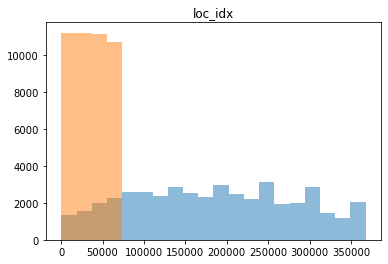

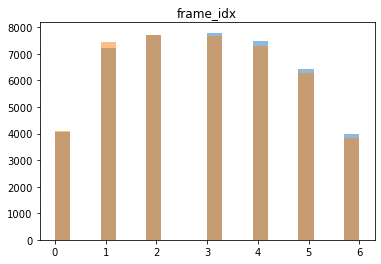

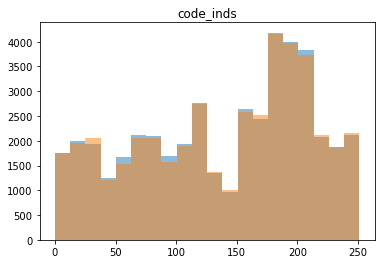

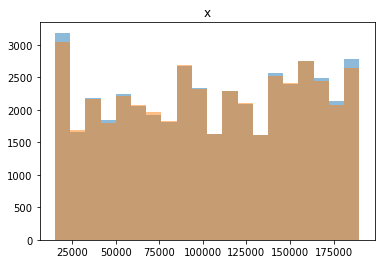

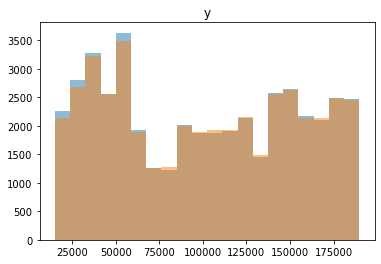

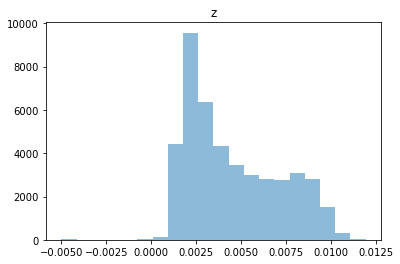

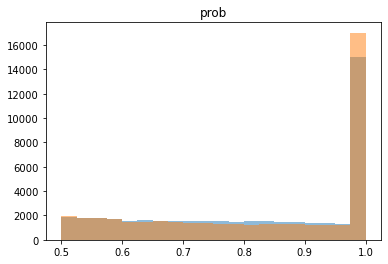

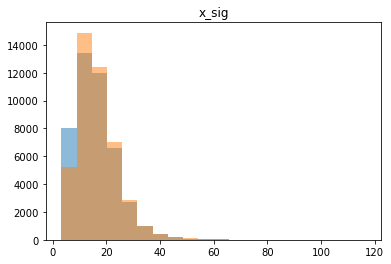

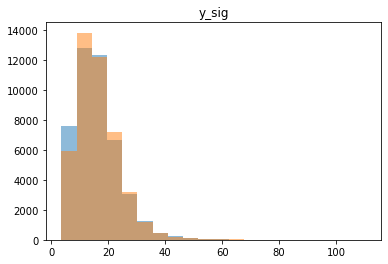

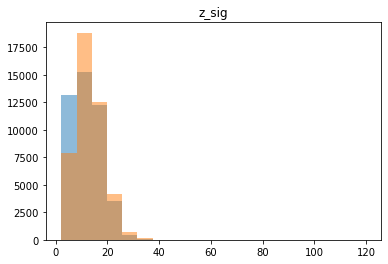

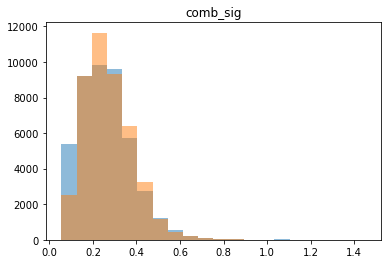

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> dtype('<U32')

In [1001]:
for k in res_df1.keys():
    bins = np.linspace(res_df1[k].min(), res_df1[k].max(), 21)
    plt.hist(sel_int_ch(res_df1, code_ref)[k], alpha=0.5, bins=bins)
    plt.hist(sel_int_ch(res_df2, code_ref)[k], alpha=0.5, bins=bins)
    plt.title(k)
    plt.show()